### Imports

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")


### Distância de Minkowski

In [2]:
def calculateDist(p1, p2, n):
    return ((abs(p1[0] - p2[0])**n) + (abs(p1[1] - p2[1])**n)) ** (1/n)

* __Distância Manhattan__ __->__  n = 1

* __Distância Euclidiana__ __->__  n = 2


In [3]:
def calculateDistances(pontos, n):
    distances = [[] for _ in range(len(pontos))]
    for i, p1 in enumerate(pontos):
        for j, p2 in enumerate(pontos):
            distances[i].append(calculateDist(p1, p2, n))
    return distances

In [4]:
pontos = [[6, 3], [-10, -4], [-9, 0], [5, 5], [8, 3], [7, 2], [4, 4], [7, 6], [-8, -2], [2, 5]]
distMatrix = calculateDistances(pontos, 2)

### Função para vizualização

Para pontos em duas dimensões

In [5]:
def plotClusters2D(clusters,n):
    
    plt.figure(figsize=(8, 8))
    colors = plt.get_cmap('Set1', len(clusters))  
    
    for i, cluster in enumerate(clusters):
        cluster_points = np.array(cluster)
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], color=colors(i), label=f'Cluster {i + 1}')
        
        #Centro do cluster
        center = np.array(cluster[0])
        plt.scatter(center[0], center[1], color='black', marker='x')
        
        #Raio
        max_dist = max([calculateDist(center,p,n) for p in cluster])
        circle = plt.Circle(center, max_dist, color=colors(i), fill=False, linestyle='--')
        plt.gca().add_patch(circle)
        plt.text(center[0], center[1] + max_dist + 0.3, f'Raio: {max_dist:.2f}', color=colors(i), ha='center')
    
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(f'Clusters')
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.show()


Para pontos em três dimensões

In [6]:
def plotClusters3D(clusters, n):
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    colors = plt.get_cmap('tab20b', len(clusters))
    
    for i, cluster in enumerate(clusters):
        cluster_points = np.array(cluster)
        ax.scatter(cluster_points[:, 0], cluster_points[:, 1], cluster_points[:, 2], color=colors(i), label=f'Cluster {i + 1}')
        
        # Centro do cluster
        center = np.mean(cluster_points, axis=0)
        ax.scatter(center[0], center[1], center[2], color='black', marker='x')
        
        # Raio
        max_dist = max([calculateDist(center, p, n) for p in cluster])
        
        #Nesse caso temos uma esfera e não circulo
        u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
        x = max_dist * np.cos(u) * np.sin(v) + center[0]
        y = max_dist * np.sin(u) * np.sin(v) + center[1]
        z = max_dist * np.cos(v) + center[2]
        
        ax.plot_surface(x, y, z, color=colors(i), alpha=0.3, edgecolor='none')
        ax.text(center[0], center[1], center[2] + max_dist + 0.3, f'Raio: {max_dist:.2f}', color=colors(i), ha='center')
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Clusters')
    ax.legend()
    plt.show()

Para várias dimensões a vizualização em gráficos fica inviável

In [7]:
def printClusters(clusters,n):
    
    print(f"Clusters encontrados: {len(clusters)}")
    for i, cluster in enumerate(clusters):
        print(f"Cluster {i + 1}:")
        print(f"Pontos: {cluster}")
        max_dist = max([calculateDist(cluster[0], p,2) for p in cluster])
        print(f"Raio do Cluster: {max_dist}")

### Primeira versão do algoritmo 2-aproximado

Nessa versão  o intervalo para o raio ótimo é refinado até uma largura definida. Primeiramente vamos definir funções auxiliares para conseguir fazer o algoritmo:

In [8]:
#Função responsável por determinar se é possível dado um conjunto de pontos achar k clusters de raio maximo 2 rmax

def findSolution(pontos, rmax, k,n):
    success = False
    solution = []
    clusters = []
    pts = pontos[:]
    
    while pts:
        current_p = pts.pop(0)
        solution.append(current_p)
        cluster = [current_p]
        
        pts_to_remove = []
        for p in pts:
            if calculateDist(current_p, p, n) < 2 * rmax:
                cluster.append(p)
                pts_to_remove.append(p)
        
        for p in pts_to_remove:
            pts.remove(p)
        
        clusters.append(cluster)
    
    if len(solution) <= k:
        success = True
    
    return success, clusters


Agora podemos ir para a implementação do algoritmo em si:

In [9]:
def k_clustering(pontos,porcentagem_largura,k_clusters,n_distancia,distMatrix):
    limite_superior = max(max(row) for row in distMatrix)
    limite_inferior = 0
    
    largura_total = limite_superior - limite_inferior 
    
    raio = limite_superior/2
    
    while (limite_superior-limite_inferior) >= (porcentagem_largura*largura_total):
        sucess, clusters = findSolution(pontos, raio, k_clusters,n_distancia)
        if sucess:
            limite_superior = raio
            raio = limite_superior/2
        else:
            limite_inferior = raio
            raio = raio + raio/2
            
    raios = [[] for _ in range(len(clusters))]
    for i, cluster in enumerate(clusters):
        center = cluster[0]
        max_dist = max([distMatrix[pontos.index(center)][pontos.index(p)] for p in cluster])
        raios[i].append(max_dist)
    
    return clusters, raios

In [10]:
clusters = k_clustering(pontos,0.25,3,1,distMatrix)

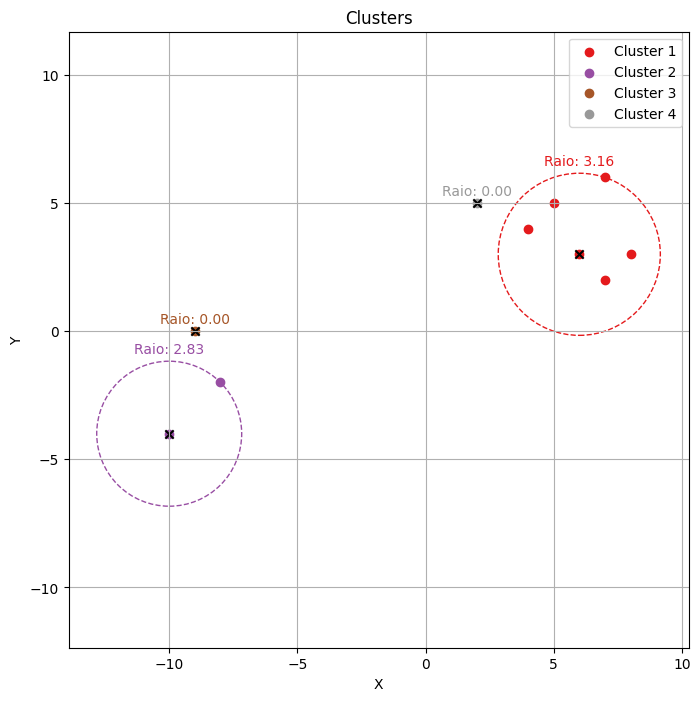

In [11]:
plotClusters2D(clusters[0],2)

### Segunda versão do algoritmo 2-aproximado

Nessa os centros são escolhidos para maximizar a distância entre os centros previamente escolhidos

In [12]:
#Calcula o ponto com a máxima distância mínima aos pontos em centers
def mostDistant(pontos, centers, n):
    maxDist = 0
    for p in pontos:
        if p not in centers:
            minDist = np.inf
            for c in centers:
                dist = distMatrix[pontos.index(p)][pontos.index(c)]
                if dist < minDist:
                    minDist = dist
            if minDist > maxDist:
                maxDist = minDist
                p_choice = p
    return p_choice

#Determina os centros dos clusters
def getCenters(pontos,k_clusters,n):
    if k_clusters >= len(pontos):
        return pontos
    
    centers = [pontos[0]]
    while (len(centers) < k_clusters):
        s = mostDistant(pontos, centers, n)
        centers.append(s)
    return centers

#Determina o centro mais próximo do ponto p
def find_closest_center(centers, p, n):
    minDist = np.inf
    for c in centers:
        dist = distMatrix[pontos.index(p)][pontos.index(c)]
        if dist < minDist:
            minDist = dist
            closest_center = c
    return closest_center

#Determina os clusters por meio da maximização dos centros já escolhidos
def makeClusters(pontos, k_clusters, n):
    centers = getCenters(pontos, k_clusters, n)
    clusters = [[c] for c in centers] # inicializa os clusters apenas com o centro
    for p in pontos:
        closest_center = find_closest_center(centers, p, n)
        clusters[centers.index(closest_center)].append(p)
    # calcula o raio de cada cluster
    raios = [[] for _ in range(len(clusters))]
    for i, cluster in enumerate(clusters):
        center = cluster[0]
        max_dist = max([distMatrix[pontos.index(center)][pontos.index(p)] for p in cluster])
        raios[i].append(max_dist)

    return clusters, raios


### Kmeans

In [13]:
from sklearn.cluster import KMeans

def performKmeans(pontos, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(pontos)
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_

    clusters = [[c] for c in centers]
    for i, label in enumerate(labels):
        clusters[label].append(pontos[i])

    for i, cluster in enumerate(clusters):
        clusters[i] = np.array(list(dict.fromkeys(map(tuple, cluster))))

    # plotClusters2D(clusters,2)

### Testes

In [14]:
from datetime import datetime
def executeAll(pontos, percentage, k_clusters, n_distance, distMatrix):
    start_time = datetime.now()
    clusters_1, raios_1 = k_clustering(pontos, percentage, k_clusters, n_distance, distMatrix)
    clusters_2, raios_2 = makeClusters(pontos, k_clusters, n_distance)
    performKmeans(pontos, k_clusters)
    end_time = datetime.now()
    duration = end_time - start_time
    return duration # modificar para retornar duração, raios e métricas de avaliação

In [15]:
# testando para diferentes distâncias
distances = [1, 2, 3, 4, 5]
durations = []
for d in distances:
    duration = executeAll(pontos, 0.25, 2, d, distMatrix) # 25% da largura total, 2 clusters, distância d variando
    durations.append(duration.total_seconds())

print(durations)

[0.210631, 0.005967, 0.007453, 0.005847, 0.004653]


Geração de datasets sintéticos

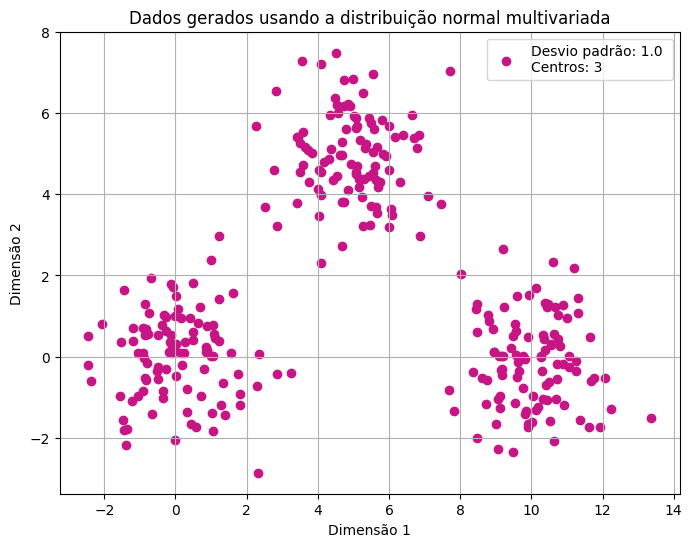

In [16]:
import numpy as np
import matplotlib.pyplot as plt

def generateSyntheticData(centers, std_dev, num_points_per_center):
    pontos = []
    
    for i, center in enumerate(centers):
        points = np.random.multivariate_normal(mean=center, cov=[[std_dev**2, 0], [0, std_dev**2]], size=num_points_per_center)
        pontos.append(points)
    
    return np.vstack(pontos)

# Parâmetros
centers = [(0, 0), (5, 5), (10, 0)]  # o que fazer com as coordenadas dos centros? 
std_dev = 1.0  # Desvio padrão para controle da sobreposição
num_points_per_center = 100  # Número de pontos por centro

pontos = generateSyntheticData(centers, std_dev, num_points_per_center)

# Plotar os dados
plt.figure(figsize=(8, 6))
plt.scatter(pontos[:, 0], pontos[:, 1], color='mediumvioletred', label=f'Desvio padrão: {std_dev} \nCentros: {len(centers)}')
plt.legend()
plt.xlabel('Dimensão 1')
plt.ylabel('Dimensão 2')
plt.title('Dados gerados usando a distribuição normal multivariada')
plt.grid(True)
plt.show()
